In [1]:
from gensim.models import Doc2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import glob
import numpy as np
import pandas as pd
import cv2

C:\Users\woodw\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\woodw\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from keras.layers import Input, merge, Concatenate, Dense, Dropout, Conv2D, Add, Dot, Lambda, Conv2DTranspose, Dot, Activation, Reshape, BatchNormalization, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Multiply, LeakyReLU, Flatten, MaxPool2D, MaxPool3D, Embedding, GRU
from keras.layers.convolutional import Convolution2D, UpSampling2D, SeparableConv2D, UpSampling3D
from keras.layers import PReLU, LeakyReLU
from keras.models import Model
from keras.models import load_model
import keras.backend as K
from keras import layers
from keras.preprocessing.sequence import pad_sequences

from nltk.tokenize import sent_tokenize, word_tokenize 
import tensorflow as tf

Using TensorFlow backend.


In [3]:
img_paths = glob.glob('cleaned-data\*.jpg')

In [4]:
captions = pd.read_csv('./coco-captions-2017-clean.csv')

In [5]:
annot_list = captions.values[:128]
data = [] 
corpus_dict = {}
# iterate through each caption 
max_sequence_length = float("-inf")
for row in annot_list: 
    temp = [] 
      
    #tokenize the captions into words 
    for j in word_tokenize(row[2]): 
        temp.append(j.lower()) 
        corpus_dict[j.lower()] = 0
    if len(temp) > max_sequence_length:
        max_sequence_length = len(temp)
    data.append(temp) 

for index, word in enumerate(corpus_dict.keys()):
    corpus_dict[word] = index + 1
    
corpus_size = len(corpus_dict.keys())

In [89]:
corpus_size

434

In [6]:
captions_X = []
caption_strings = []

for row in annot_list:
    caption_conv = []
    for word in word_tokenize(row[2].lower()):
        caption_conv.append(corpus_dict[word])
    captions_X.append(np.array(caption_conv))
    caption_strings.append(row[2].lower())
    
    
    

In [7]:
captions_X = pad_sequences(captions_X, maxlen=27, value=0, padding='post')

In [8]:
captions_X = np.array(captions_X)

In [85]:
print (caption_strings[0])

closeup of bins of food that include broccoli and bread.


In [12]:
# annot_df = pd.read_csv('./coco-captions-2017-clean.csv')
# annot_list = annot_df.values[:1167]
# data = [] 
# corpus_dict = {}
# # iterate through each caption 
# max_sequence_length = float("-inf")
# for row in annot_list: 
#     temp = [] 
      
#     #tokenize the captions into words 
#     for j in word_tokenize(row[2]): 
#         temp.append(j.lower()) 
#         corpus_dict[j.lower()] = 0
#     if len(temp) > max_sequence_length:
#         max_sequence_length = len(temp)
#     data.append(temp) 
  
# for index, word in enumerate(corpus_dict.keys()):
#     corpus_dict[word] = index + 1
    
# corpus_size = len(corpus_dict.keys())
# print("corpus size: {}".format(corpus_size))
# print("max sequence length: {}".format(max_sequence_length))

In [11]:
def data_loader(file_path):
    img_paths = glob.glob(file_path + '/*')
    data = []
    for img_path in img_paths:
        
        data.append(cv2.imread(img_path) / 255.0)
    return np.array(data)

In [12]:
imgs_all = data_loader('./cleaned-data/')
imgs_y = imgs_all[:128]

In [26]:
autoencoder = load_model('./autoencoder-v2-models/autoencoder-v2-9k-epochs.h5')

In [27]:
decoder = autoencoder.layers[2]

In [28]:
for layer in decoder.layers:
    layer.trainable = False
decoder.trainable = False

In [29]:
def build_intermediate_model(input_shape, name='textencoder', encode_channels=[4, 8, 16, 32]):
    embedding_size = 64
    gru_size = 1024
    input_length = 27
    input_layer = Input(shape=input_shape)
    encoder_block = Embedding(434, 64, input_length=27)(input_layer)
    
    print(encoder_block)
    
    embedded_seq, state_i = GRU(gru_size, return_state=True)(encoder_block)
#     for i in range(input_length):
        
#         word = Lambda(lambda x : x[:,i,:])(encoder_block)
        
#         # first word in sequence
#         word = Reshape((-1,embedding_size))(word)
        
#         if(i == 0):
#             embedded_seq, state_i = GRU(gru_size, activation=None, return_state=True, return_sequences=True, name=str(i)+'_GRU')(word)
#             state_i = LeakyReLU()(state_i)
#         else:
#             embedded_seq, state_i = GRU(gru_size, activation=None, return_state=True, return_sequences=True, name=str(i)+"_GRU")(word, initial_state=state_i)
#             state_i = LeakyReLU()(state_i)
        
 
    encoder_block = Reshape((32, 32, 1))(state_i)
#     encoder_block = Reshape((8, 8, 1))(state_i)
#     encoder_block = Conv2DTranspose(1, 3, strides=2, padding='same')(encoder_block)
#     encoder_block = LeakyReLU()(encoder_block)
#     encoder_block = Conv2DTranspose(1, 3, strides=2, padding='same')(encoder_block)
#     encoder_block = LeakyReLU()(encoder_block)
    
    for index, channel in enumerate(encode_channels):
        encoder_block = Conv2D(channel, 3, strides=1, padding='same')(encoder_block)
        encoder_block = LeakyReLU()(encoder_block)

    
    output_layer = encoder_block
    return Model(input_layer, output_layer, name=name)

In [30]:
model_intermediate = build_intermediate_model((27,), encode_channels=[4, 6, 8, 12, 16, 24, 32])

Tensor("embedding_3/embedding_lookup/Identity:0", shape=(?, 27, 64), dtype=float32)


In [31]:
model_intermediate.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 27)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 27, 64)            27776     
_________________________________________________________________
gru_3 (GRU)                  [(None, 1024), (None, 102 3345408   
_________________________________________________________________
reshape_3 (Reshape)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 4)         40        
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 6)         222       
__________

In [32]:
len(model_intermediate.layers)

18

In [33]:
def build_combined_model():
    input_caption = Input(shape=(27,))
    latent_representation = model_intermediate(input_caption)
    decoded_img = decoder(latent_representation)
    autoencoder = Model(input_caption, decoded_img, name="text2img")
    return autoencoder

In [34]:
model_text2img = build_combined_model()

In [35]:
model_text2img.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 27)                0         
_________________________________________________________________
textencoder (Model)          (None, 32, 32, 32)        3386930   
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       51763     
Total params: 3,438,693
Trainable params: 3,386,930
Non-trainable params: 51,763
_________________________________________________________________


In [169]:
model_text2img.compile(optimizer='nadam', loss='mse', metrics=['accuracy'])

Epoch 1/100
128/128 [==============================] - 0s 3ms/step - loss: 0.0139 - acc: 0.6838
Epoch 2/100
128/128 [==============================] - 0s 2ms/step - loss: 0.0141 - acc: 0.6831
Epoch 3/100
128/128 [==============================] - 0s 2ms/step - loss: 0.0139 - acc: 0.6824
Epoch 4/100
128/128 [==============================] - 0s 2ms/step - loss: 0.0137 - acc: 0.6902
Epoch 5/100
128/128 [==============================] - 0s 2ms/step - loss: 0.0138 - acc: 0.6817
Epoch 6/100
128/128 [==============================] - 0s 2ms/step - loss: 0.0138 - acc: 0.6918
Epoch 7/100
128/128 [==============================] - 0s 2ms/step - loss: 0.0137 - acc: 0.6914
Epoch 8/100
128/128 [==============================] - 0s 2ms/step - loss: 0.0139 - acc: 0.6845
Epoch 9/100
128/128 [==============================] - 0s 2ms/step - loss: 0.0139 - acc: 0.6887
Epoch 10/100
128/128 [==============================] - 0s 2ms/step - loss: 0.0138 - acc: 0.6941
Epoch 11/100
128/128 [=================

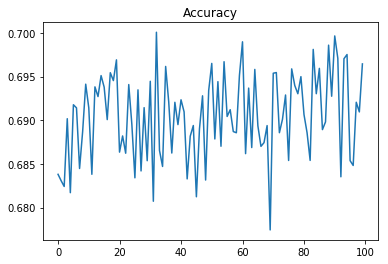

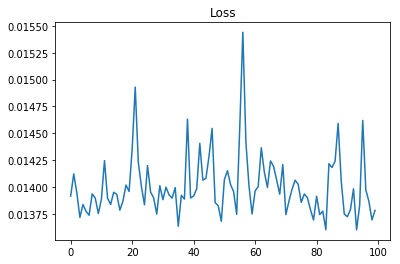

In [208]:
history = model_text2img.fit(captions_X, imgs_y, epochs=100, batch_size=32, shuffle=True)
plot_history(history)

In [ ]:
for i in range (10, 50):
    history = model_text2img.fit(captions_X, imgs_y, epochs=1000, batch_size=32, shuffle=True)
    print(str(i) + 'k epochs~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    model_text2img.save('.\\text2img-models\\text2img-' + str(i) + 'k-epochs.h5')
    plot_history(history)
#     show_converted(4)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

In [14]:
# model_text2img = load_model('./text2img-models/text2img-49k-epochs.h5')
model_text2img.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 27)                0         
_________________________________________________________________
textencoder (Model)          (None, 32, 32, 32)        520710    
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       51763     
Total params: 572,473
Trainable params: 520,710
Non-trainable params: 51,763
_________________________________________________________________


closeup of bins of food that include broccoli and bread.


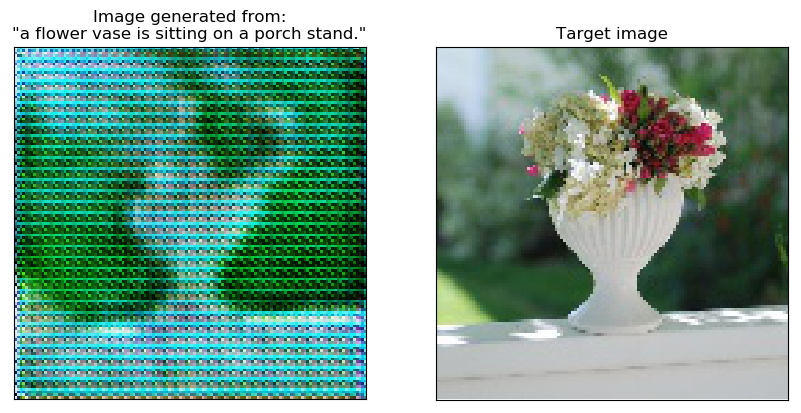

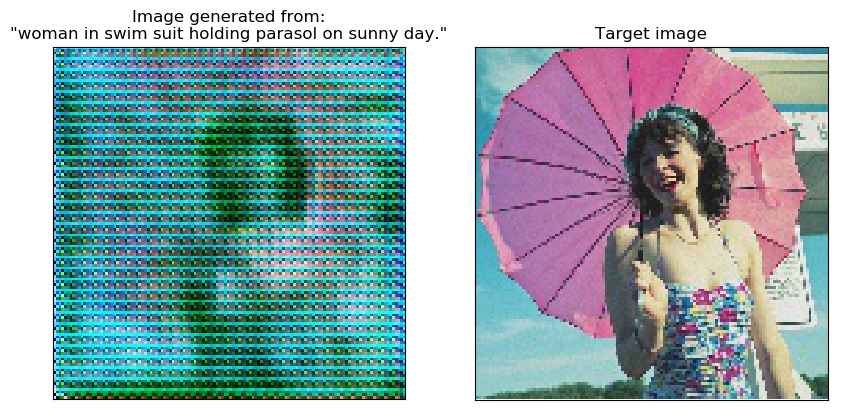

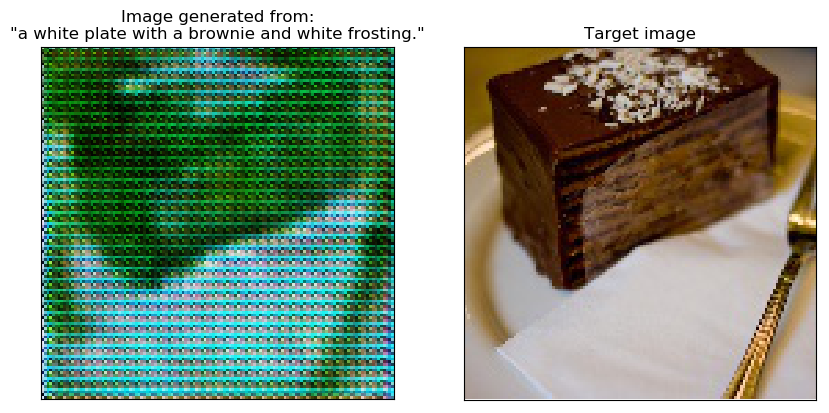

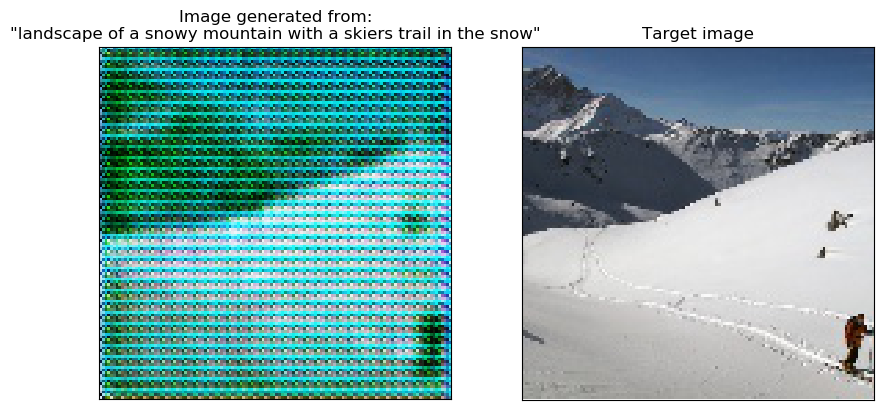

In [210]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
# figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')
def rgb_imshow(img):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(cv2.cvtColor((img).astype(np.float32), cv2.COLOR_BGR2RGB))
#     plt.show()
def show_converted(img_index, step_count=None):
    
    # print(caption_strings[img_index])
    figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')
    img_input = imgs_y[img_index] #subset_X[img_index]
    plt.subplot(1,2,2)
    plt.title("Target image")
    rgb_imshow(img_input)
    
    plt.subplot(1,2,1)
    plt.title("Image generated from:\n\"" + caption_strings[img_index] +"\"")
    decoded_img = model_text2img.predict(np.array([captions_X[img_index]]), steps=step_count)[0]
    
#     figure(num=None, figsize=(10, 10), facecolor='w', edgecolor='k')
    rgb_imshow(decoded_img)
    plt.savefig('./full-model-imgs/img-' + str(img_index),bbox_inches='tight')


show_converted(2)
show_converted(4)
show_converted(18)
show_converted(65)
print(caption_strings[0])

# decoded_img1 = model_text2img.predict(np.array([captions_X[4]]))[0]
# decoded_img2 = model_text2img.predict(np.array([captions_X[5]]))[0]

# flat_img = np.array(decoded_img2 - decoded_img1)
# flat_img = flat_img.flatten()
# nonzero_elems = [x for x in flat_img if x != 0]
# print (len(decoded_img1.flatten()))
# print (len(nonzero_elems))
# print (np.max(flat_img))


In [ ]:
model_text2img.predict(captions_X[img_index], steps=None)[0]

In [28]:
def plot_history(history):
    plt.plot(history.history['acc'])
    plt.title("Accuracy")
    plt.show()
    plt.plot(history.history['loss'])
    plt.title("Loss")
    plt.show()

In [ ]:
np.shape(model_text2img.predict(np.array([captions_X[0]]))[0])

In [ ]:
from keras.utils import plot_model

plot_model(model_intermediate,  show_shapes=True, to_file='./vis/text2img-vis.jpg')